# Forecasting the Neighborhood Change and Detecting Gentrification with Yelp Data

**Data Source**
<br>
Rent data - median studio price by zipcode *downloaded from zillow 
<br>
Yelp data - Yelp API

## Visualising the changes in NYC neighborhoods 
#### - from 2011/11 to 2018/08 - 

In [43]:
# importing all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import math
# from pyproj import Proj, transform
# from sklearn.preprocessing import normalize
# from sklearn.model_selection import train_test_split
# import sklearn.linear_model as linreg
# from sklearn.metrics import accuracy_score
# import seaborn as sns
# import datetime
# import ast
# import statsmodels.formula.api as smf
# from sklearn.linear_model import Lasso, Ridge
# from scipy import stats
# from bokeh.layouts import column, row, widgetbox
# from bokeh.models import CustomJS, Slider, Toggle
# from bokeh.models import ColumnDataSource, HoverTool, LogColorMapper, LogTicker, ColorBar
# from bokeh.plotting import figure, show, output_file, ColumnDataSource
# from bokeh.io import push_notebook, output_notebook
# from ipywidgets import *
# import ipywidgets as widgets
# from shapely.geometry import Point, Polygon,MultiPoint, MultiPolygon
warnings.filterwarnings("ignore")
# %matplotlib inline

In [ ]:
!pip install Fiona==1.6.0
!pip install geopandas

In [25]:
import geopandas as gpd
# !python -m pip install --upgrade pip

  Found existing installation: pip 18.1
    Uninstalling pip-18.1:
      Successfully uninstalled pip-18.1


In [8]:
# calculate statistics
ny_rent_studio = pd.read_csv('C:/Users/Ayushee/Dropbox/Columbia/Spring 2019/Business Analytics/Group Project/gentrification_yelp-master/gentrification_yelp-master/ny_rent_studio.csv', index_col = 0)  # import csv
mean_rent = ny_rent_studio['%_increase'].mean() # find the mean % increase of rent in NYC area
# print('''Average rent increase in Manhattan, Queens, Brooklyn, and Bronx from Nov. 2011 to Aug. 2018 is {:.2f}%'''.format(mean_rent))

## find out how many % of NYC neighborhoods have experienced above mean rent increase
# print(len(ny_rent_studio[ny_rent_studio['%_increase']>mean_rent])/len(ny_rent_studio[~ny_rent_studio['%_increase'].isnull()]))
# len(ny_rent_studio[ny_rent_studio['%_increase']<mean_rent])/len(ny_rent_studio[~ny_rent_studio['%_increase'].isnull()])

FileNotFoundError: File b'C:/Users/Ayushee/Dropbox/Columbia/Spring 2019/Business Analytics/Group Project/gentrification_yelp-master/gentrification_yelp-master/ny_rent_studio.csv' does not exist

- Median studio rent in Manhattan, Queens, Brooklyn, and Bronx has increased by **21.04%** in average since Nov. 2011 to Aug. 2018 
<br>
- Roughly **38.71%** of NYC neighborhood (zipcode level) have experienced above mean ( > 21.04%) rent increase

In [14]:
# import csv files for mapping
# ny_qn_bk_studio_df = pd.read_csv('C:/Users/Ayushee/Dropbox/Columbia/Spring 2019/Business Analytics/Group Project/gentrification_yelp-master/gentrification_yelp-master/csv/EDA/ny_qn_bk_studio_df_bokeh.csv.icloud', index_col = 0)
shape_fiona = gpd.read_file('new.shp') # shape file
# clean up the files
shape_fiona_for_plot = shape_fiona[['ZIPCODE', 'geometry']]
shape_fiona_for_plot.columns =  ['RegionName', 'geometry']
shape_fiona_for_plot.RegionName = shape_fiona_for_plot.RegionName.astype('int')

NameError: name 'gpd' is not defined

In [10]:
# create list of lists for mapping (x = latitude, y = longitude)
district_zipcode = shape_fiona_for_plot.RegionName
district_x = [ [list(shape_fiona_for_plot.geometry[i].exterior.coords)[j][0]
              for j in range(0,len(list(shape_fiona_for_plot.geometry[i].exterior.coords)))]
              for i in range(0,len(shape_fiona_for_plot))]
district_y = [ [list(shape_fiona_for_plot.geometry[i].exterior.coords)[j][1]
                for j in range(0,len(list(shape_fiona_for_plot.geometry[i].exterior.coords)))]
              for i in range(0,len(shape_fiona_for_plot))]

# create rent dictionary for mapping (will be used to update the color of polygons)
year = ny_qn_bk_studio_df.columns[7:89]
rent_list = [ny_qn_bk_studio_df[year_] for year_ in year]
rent_dict = dict(zip(year,rent_list))
data = dict(x=district_x, y=district_y, name=district_zipcode,
            rate=rent_list[0], **rent_dict)
source = ColumnDataSource(data)

In [12]:
output_notebook()

custom_colors = ['#f2f2f2', '#fee5d9', '#fcbba1', '#fc9272', '#fb6a4a', '#de2d26']
color_mapper = LogColorMapper(palette=custom_colors)  

TOOLS = "pan,wheel_zoom,reset,hover,save"
p = figure(
    title="Median Rental Prices - Studio Apartments", tools=TOOLS,
    x_axis_location=None, y_axis_location=None
)
p.grid.grid_line_color = None
p.patches('x', 'y', source=source,
          fill_color={'field': 'rate', 'transform': color_mapper},
          fill_alpha=0.8, line_color="black", line_width=0.3)

color_bar = ColorBar(color_mapper=color_mapper, ticker=LogTicker(),
                     label_standoff=12, border_line_color=None, location=(0,0))

p.add_layout(color_bar, 'right')

hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [("zipcode", "@name"),("rent ($)", "@rate"),("(Long, Lat)", "($x, $y)")]
# show(p, notebook_handle = True)

# w = widgets.SelectionSlider(options=year,value=year[0],disabled=False,continuous_update=False,
#                                                orientation='horizontal',readout=True)
def update(year_month):
    source.data['rate'] = source.data[year_month]
    show(p, notebook_handle=True)
    push_notebook()
    
interact(update, year_month = ['2011-11','2014-11','2016-11', '2018-08'])

Loading BokehJS ...

interactive(children=(Dropdown(description='year_month', options=('2011-11', '2014-11', '2016-11', '2018-08'),…

<function __main__.update(year_month)>

In [16]:
# list top 11 neighborhoods with the fastest rent increase
sorted_rent_increase = ny_rent_studio.sort_values(['%_increase'], ascending = False)
sorted_rent_increase_top_10 = sorted_rent_increase.loc[:10]
region_name_top_10 = sorted_rent_increase_top_10.loc[:,'RegionName':'CountyName']
increase_top_10 = sorted_rent_increase_top_10.loc[:,'2018-08':'%_increase']
sorted_rent_top_10 = pd.concat([region_name_top_10, increase_top_10], axis = 1)
sorted_rent_top_10 = sorted_rent_top_10.reset_index(drop = True)
sorted_rent_top_10 = sorted_rent_top_10.loc[:10]
sorted_rent_top_10['neighborhood'] = ['Flushing', 'Forest Hills', 'Bushwick', 'Rego Park', 'Elmhurst','Midtown East', 'Upper West Side', 'Meatpacking', 'Battery Park', 'City Hall', 'Williamsburg']
sorted_rent_top_10 = sorted_rent_top_10.drop(['City', 'Metro', 'State'], axis = 1)
sorted_rent_top_10.columns = ['zipcode', 'Borough','Rent 2018/08', '%_increase since 2011/11', 'neighborhood']
sorted_rent_top_10["%_increase since 2011/11"] = sorted_rent_top_10["%_increase since 2011/11"].round(2)
sorted_rent_top_10 = sorted_rent_top_10.replace('New York', "Manhattan")
sorted_rent_top_10 = sorted_rent_top_10.replace('Kings', "Brooklyn")
sorted_rent_top_10 = sorted_rent_top_10.drop(['zipcode'], axis = 1)

# list bottom 11 neighborhoods with the fastest rent increase
sorted_rent_increase_asc = ny_rent_studio.sort_values(['%_increase'], ascending = True)
sorted_rent_increase_asc = sorted_rent_increase_asc.reset_index(drop = True)
sorted_rent_increase_asc_top_10 = sorted_rent_increase_asc.loc[:10]
region_name_bottom_10 = sorted_rent_increase_asc_top_10.loc[:,'RegionName':'CountyName']
increase_bottom_10 = sorted_rent_increase_asc_top_10.loc[:,'2018-08':'%_increase']
sorted_rent_bottom_10 = pd.concat([region_name_bottom_10, increase_bottom_10], axis = 1)
sorted_rent_bottom_10['neighborhood'] = ['Midtown West', 'Upper East Side', 'East Harlem', 'East Village', 'Yorkville','Lenox Hill', 'Yorkville', 'Upper West Side', 'Murray Hill','Upper West Side','Yorkville'  ]
sorted_rent_bottom_10 = sorted_rent_bottom_10.drop(['City', 'Metro', 'State'], axis = 1)
sorted_rent_bottom_10.columns = ['zipcode', 'Borough','Rent 2018/08', '%_increase since 2011/11', 'neighborhood']
sorted_rent_bottom_10["%_increase since 2011/11"] = sorted_rent_bottom_10["%_increase since 2011/11"].round(2)
sorted_rent_bottom_10 = sorted_rent_bottom_10.replace('New York', "Manhattan")
sorted_rent_bottom_10 = sorted_rent_bottom_10.drop(['zipcode'], axis = 1)

In [14]:
def update_df(select = 'Neighborhoods with the Fastest Rent Increase'):
    if select == 'Neighborhoods with the Fastest Rent Increase':
        display(sorted_rent_top_10)
    if select == 'Neighborhoods with the Slowest Rent Increase':
        display(sorted_rent_bottom_10)
        
int_widget = interactive(update_df, select= ['Neighborhoods with the Fastest Rent Increase','Neighborhoods with the Slowest Rent Increase'])
int_widget.children[0].layout = Layout(width='450px')
display(int_widget)

interactive(children=(Dropdown(description='select', layout=Layout(width='450px'), options=('Neighborhoods wit…

In [115]:
yelp_williamsburg_one_hot_cumsum = pd.read_csv('csv/EDA/yelp_williamsburg_one_hot_cumsum.csv', index_col = 0)
yelp_bushwick_one_hot_cumsum = pd.read_csv('csv/EDA/yelp_bushwick_one_hot_cumsum.csv', index_col = 0)
yelp_east_harlem_one_hot_cumsum = pd.read_csv('csv/EDA/yelp_east_harlem_one_hot_cumsum.csv', index_col = 0)
yelp_chelsea_clinton_one_hot_cumsum = pd.read_csv('csv/EDA/yelp_chelsea_clinton_one_hot_cumsum.csv', index_col = 0)

yelp_cumsum_rent_williamsburg_df = pd.read_csv('csv/yelp_cumsum_rent_williamsburg.csv', index_col = ['Unnamed: 0'])
yelp_cumsum_rent_williamsburg_df.index = pd.to_datetime(yelp_cumsum_rent_williamsburg_df.index)
yelp_cumsum_rent_east_harlem_df = pd.read_csv('csv/yelp_cumsum_rent_east_harlem.csv', index_col = ['Unnamed: 0'])
yelp_cumsum_rent_east_harlem_df.index = pd.to_datetime(yelp_cumsum_rent_east_harlem_df.index)
yelp_cumsum_rent_bushwick_df = pd.read_csv('csv/yelp_cumsum_rent_bushwick.csv', index_col = ['Unnamed: 0'])
yelp_cumsum_rent_bushwick_df.index = pd.to_datetime(yelp_cumsum_rent_bushwick_df.index)

## Detecting Gentrification using Machine Learning Algorithms

#### We've only looked at Williamsburg, and Bushwick, but can we generalize it to the whole NYC area?
- use machine learning algorithm to detect if the area is:<br>
    - **Gentrifying**: the area that was low-income in 1990 and experienced rent growth above the median SBA rent growth between 1990 and 2010-2014<br>
    - **Non-gentrifying**: the areas that started off as low-income in 1990 but experienced more modest growth<br>
    - **Higher-income**: the areas that had higher incomes in 1990.

- for this, some of yelp data are combined with demographic data from 2016 Census

*Source: http://furmancenter.org/files/sotc/Part_1_Gentrification_SOCin2015_9JUNE2016.pdf*
  


In [9]:
from sklearn.model_selection import train_test_split, GridSearchCV
# from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from textwrap import wrap

In [10]:
import pandas as pd

In [12]:
zipcode_neighborhood_df_test_exc_income = pd.read_csv('zipcode_neighborhood_df_test_exc_income.csv', index_col = 0)

In [13]:
# len(zipcode_neighborhood_df_test_exc_income['gentrification_label']==0)
# zipcode_neighborhood_df_test_exc_income[zipcode_neighborhood_df_test_exc_income['zipcodes']==10002]
## 0 - high income
## 2 - getrifying
sum(zipcode_neighborhood_df_test_exc_income['gentrification_label']==0)/157 ##107 high income. 68%
sum(zipcode_neighborhood_df_test_exc_income['gentrification_label']==1)/157 ##107 high income. 7%
sum(zipcode_neighborhood_df_test_exc_income['gentrification_label']==2)/157 ##107 high income. 25%

0.2484076433121019

In [16]:
X = zipcode_neighborhood_df_test_exc_income.loc[:,'avg_rating':]
target = zipcode_neighborhood_df_test_exc_income['gentrification_label']
X = X.replace('-', 0)
X.head()

,avg_rating,avg_price,starbucks_count,bars,"%, Less than 9th grade","%, 9th to 12th grade, no diploma",% High school graduate (includes equivalency),"% Some college, no degree",% A Associate's degree,% Bachelor's degree,% Graduate or professional degree,% high school graduate or higher,% bachelor's degree or higher,% White,% African American,% American Indian and Alaska Native,% Asian,% Native Hawaiian and Other Pacific Islander,% Some other race,cafe_count
0,3.412022,1.446834,0.0,0.0,17.2,16.3,29.0,16.7,7.5,10.1,3.2,66.6,13.2,10.4,32.0,0.8,1.5,0.1,52.8,3.0
1,3.175676,1.231801,0.0,0.0,18.7,18.6,26.2,18.1,5.6,8.4,4.4,62.7,12.8,11.6,34.5,0.4,1.3,0.1,48.8,2.0
2,3.477435,1.406593,0.0,0.0,18.2,20.5,25.8,17.8,5.6,9.5,2.6,61.3,12.1,13.4,28.5,0.2,1.6,0.0,53.6,1.0
3,3.774120,1.461673,2.0,3.0,16.2,15.5,29.4,18.4,6.6,9.9,4.1,68.3,13.9,19.3,20.5,0.4,3.1,0.1,52.2,15.0
4,3.546569,1.274436,0.0,1.0,14.0,14.0,29.1,17.0,6.8,12.9,6.0,72.0,19.0,20.0,35.7,0.7,6.3,0.0,33.3,8.0


In [452]:
# # correct the class imbalance
# print(target.value_counts())
# X_resampled, y_resampled = SMOTE().fit_sample(X, target) 
# print(pd.Series(y_resampled).value_counts()) #Preview synthetic sample class distribution

#### Random Forest Classifier

In [17]:
%matplotlib inline
data_train, data_test, target_train, target_test = train_test_split(X, target)
forest= RandomForestClassifier(n_estimators= 40, max_depth= 5)
forest.fit(data_train, target_train)
feature_importances = forest.feature_importances_
feature_importance_list = [round(value, 4) for value in feature_importances]

# def plot_feature_importances(model, data):
#     n_features = data.shape[1]
#     plt.figure(figsize=(15,4))
# #     labels = [ '\n'.join(wrap(l, 35)) for l in data.columns] 
#     plt.bar(range(n_features)[:60], model.feature_importances_[:60], align='center') 
#     plt.xticks(np.arange(n_features)[:60], data.columns, rotation = 30, ha = 'right') 
#     plt.xlabel("Feature importance")
#     plt.ylabel("Feature")

# plot_feature_importances(forest, X)

# print('Train Set Score: {:0.2f}%'.format(forest.score(data_train,target_train) * 100))
# print('test set score: {:0.2f}%'.format(forest.score(data_test, target_test)*100))


feature_importance = dict(zip(X.columns, feature_importance_list))
print('\n', 'Top 10 Features:')
sorted_dict = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
for item in sorted_dict[:10]:
    print(item)
kfold_scores_forest = cross_val_score(forest, X, target, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (kfold_scores_forest.mean()*100, kfold_scores_forest.std() * 2*100))


 Top 10 Features:
('% Asian', 0.0916)
("% bachelor's degree or higher", 0.0817)
('bars', 0.07)
("% Bachelor's degree", 0.0666)
('% high school graduate or higher', 0.0649)
('%, Less than 9th grade', 0.0642)
('% Some other race', 0.0642)
('% Graduate or professional degree', 0.063)
('% High school graduate (includes equivalency)', 0.0601)
('% White', 0.06)
Accuracy: 77.78 (+/- 10.39)


|                       | Random Forest      | Gradient Boosting |  AdaBoost         |
|-----------------------|:-------------------|:------------------|:-----------------:|
|Accuracy Score (k-fold)|90.71 (+/- 12.46)   |82.66% (+/- 9.31%) |78.85% (+/- 16.16%)|

In [18]:
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

# # Import some data to play with
# iris = datasets.load_iris()
# X = iris.data
# y = iris.target

# Binarize the output
y = label_binarize(target, classes=[0, 1, 2])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
# random_state = np.random.RandomState(0)
# n_samples, n_features = X.shape
# X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train_roc, X_test_roc, y_train_roc, y_test_roc = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators= 40, max_depth= 5))
y_score = classifier.fit(X_train_roc, y_train_roc).predict_proba(X_test_roc)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(list(y_test_roc[:, i]), y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_roc.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

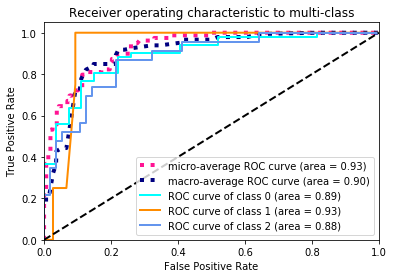

In [19]:
# Compute macro-average ROC curve and ROC area
lw = 2
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [20]:
X_train_roc.shape

(78, 20)

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
# X_train_roc, X_test_roc, y_train_roc, y_test_roc
lrn = LogisticRegression()
lrn.fit(data_train, target_train)
y_pred = lrn.predict(data_test)
np.mean(y_pred==target_test)

0.775

In [62]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(data_train, target_train)
y_pred = knn.predict(data_test)
np.mean(y_pred==target_test)

0.675

In [23]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
clf.fit(data_train, target_train)

y_pred = clf.predict(data_test)
np.mean(y_pred==target_test)

0.675

In [53]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(data_train, target_train)

y_pred = lda.predict(data_test)
np.mean(y_pred==target_test)

0.7

In [50]:
# !pip install xgboost

In [25]:
import xgboost as xgb
gbm= xgb.XGBClassifier(max_depth=10, n_estimators=300, learning_rate=0.01).fit(data_train, target_train)
y_pred = gbm.predict(data_test)
np.mean(y_pred==target_test)

0.775

### Ridge, Lasso

In [91]:
#Ridge Regression

In [92]:
from sklearn.linear_model import Ridge

In [104]:
log_ridge = Ridge() # higher the alpha value, more restriction on the coefficients; low alpha > more generalization, coefficients are barely
# restricted and in this case linear and ridge regression resembles
parameters={'alpha':[1e-15,1e-10,1e-8,1e-4,1e-3,1e-2,1,5,10,20]}
a=GridSearchCV(log_ridge, parameters, cv=5)
a.fit(data_train, target_train)
a.score(data_test, target_test)

0.59954305601013

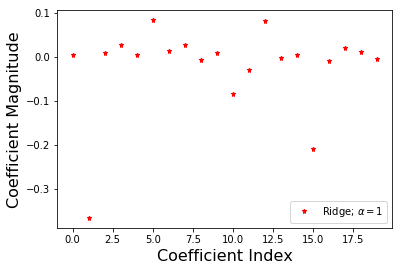

In [37]:
#Logistic with Ridge
log_ridge = Ridge(alpha=1) # higher the alpha value, more restriction on the coefficients; low alpha > more generalization, coefficients are barely
# restricted and in this case linear and ridge regression resembles
log_ridge.fit(data_train, target_train)

train_score=lrn.score(data_train, target_train)
test_score=lrn.score(data_test, target_test)
Ridge_train_score = log_ridge.score(data_train,target_train)
Ridge_test_score = log_ridge.score(data_test, target_test)


plt.plot(log_ridge.coef_,alpha=1,linestyle='none',marker='*',markersize=5,color='red',label=r'Ridge; $\alpha = 1$',zorder=7) # zorder for ordering the markers

plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=10,loc=4)
plt.show()

In [41]:
print(train_score)
print(Ridge_train_score)
print(test_score)
print(Ridge_test_score)

0.8717948717948718
0.4350792520966862
0.775
0.5618462244969497


In [42]:
from sklearn.linear_model import Lasso

In [51]:
log_lasso = Lasso(alpha=0) # higher the alpha value, more restriction on the coefficients; low alpha > more generalization, coefficients are barely
# restricted and in this case linear and ridge regression resembles
log_lasso.fit(data_train, target_train)

train_score=lrn.score(data_train, target_train)
test_score=lrn.score(data_test, target_test)
Lasso_train_score = log_lasso.score(data_train,target_train)
Lasso_test_score = log_lasso.score(data_test, target_test)


In [52]:
print(train_score)
print(Lasso_train_score)
print(test_score)
print(Lasso_test_score)

0.8717948717948718
0.4349561486393148
0.775
0.5545425956375447


In [81]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import model_selection

In [76]:
def model_performance_metrics(model, y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    if model.classes_[0] == 1:
        cm = np.array([[cm[1,1], cm[1,0]], [cm[0,1], cm[0,0]]])

    
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    return_values = [cm, 
                     'Recall (TPR) = {0:.2%}'.format(tp/(tp+fn)),
                     'Fallout (FPR) = {0:.2%}'.format(fp/(fp+tn)),
                     'Accuracy (Acc) = {0:.2%}'.format((tp+tn)/(tp+tn+fp+fn))]
    return return_values

In [79]:
lrn = LogisticRegression(solver = 'lbfgs')
lrn.fit(data_train, target_train)

THRESHOLD = 0.4
y_pred = np.where(lrn.predict_proba(data_test)[:,1] > THRESHOLD, 1, 0)

model_performance_metrics(lrn, target_test, y_pred)

C:\Users\Aman\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Aman\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Aman\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


[array([[24,  0,  0],
        [ 0,  2,  0],
        [ 8,  6,  0]], dtype=int64),
 'Recall (TPR) = 100.00%',
 'Fallout (FPR) = 0.00%',
 'Accuracy (Acc) = 100.00%']

In [90]:
#Cross VALIDATION
kfold = model_selection.KFold(n_splits=10)
lrn = LogisticRegression()
lrn.fit(data_train, target_train)

results= model_selection.cross_val_score(lrn, X, target, cv=kfold)
print("Accuracy: %.3f%% (%.3f%%)"% (results.mean()*100.0, results.std()*100.0))

# seed = 7
# kfold = model_selection.KFold(n_splits=10, random_state=seed)

Accuracy: 67.208% (16.894%)


In [75]:
lrn = LogisticRegression(penalty='l2',solver='sag')
lrn.fit(data_train, target_train)

THRESHOLD = 0.4
y_pred = np.where(lrn.predict_proba(data_test)[:,1] > THRESHOLD, 1, 0)

model_performance_metrics(lrn, y_test, y_pred)

C:\Users\Aman\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Aman\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Aman\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.625

In [74]:
lrn = LogisticRegression(penalty='l2',solver='newton-cg')
lrn.fit(data_train, target_train)

THRESHOLD = 0.4
y_pred = np.where(lrn.predict_proba(data_test)[:,1] > THRESHOLD, 1, 0)

model_performance_metrics(lrn, y_test, y_pred)

0.65